In [2]:
! pip install wordcloud lazypredict

In [1]:
import pandas as pd
from sklearn.utils import resample
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, \
    roc_curve, precision_recall_curve
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pickle
import time

In [3]:
df_2 = pd.read_csv("attack_parsed_dataset.csv")
df_6 = pd.read_csv("twitter_racism_parsed_dataset.csv")
df_7 = pd.read_csv("twitter_sexism_parsed_dataset.csv")

df = pd.concat([ df_2, df_6, df_7], ignore_index=True)
df

,index,Text,ed_label_0,ed_label_1,oh_label,id,Annotation
0,0,`- This is not ``creative``. Those are the di...,1.000000,0.000000,0.0,NaN,NaN
1,1,` :: the term ``standard model`` is itself le...,1.000000,0.000000,0.0,NaN,NaN
2,2,"True or false, the situation as of March 200...",1.000000,0.000000,0.0,NaN,NaN
3,3,"Next, maybe you could work on being less cond...",0.555556,0.444444,0.0,NaN,NaN
4,4,This page will need disambiguation.,1.000000,0.000000,0.0,NaN,NaN
...,...,...,...,...,...,...,...
144211,5.76422824501379E+017,@RaikonL @finaleve @mja333 WHY DO YOU HATE FRE...,NaN,NaN,0.0,5.76422824501379E+017,none
144212,4.64045547473498E+017,It is unconscionable that our regulatory bodie...,NaN,NaN,0.0,4.64045547473498E+017,none
144213,5.54705698508919E+017,@Dartanveerahmad @Janx53 @geehall1 We want ISI...,NaN,NaN,0.0,5.54705698508919E+017,none
144214,5.7560079584598E+017,#mkr Unbelievable how low Kat &amp; Andre wil...,NaN,NaN,0.0,5.7560079584598E+017,none


In [4]:
df = df[['index', 'oh_label', 'Text']]
df.head()

,index,oh_label,Text
0,0,0.0,`- This is not ``creative``. Those are the di...
1,1,0.0,` :: the term ``standard model`` is itself le...
2,2,0.0,"True or false, the situation as of March 200..."
3,3,0.0,"Next, maybe you could work on being less cond..."
4,4,0.0,This page will need disambiguation.


In [5]:
# Before renaming the columns
print("\nBefore modifying column names:\n", df.columns)

df.rename(columns={'index': 'id', 'oh_label': 'label', 'Text': 'tweet'}, inplace=True)

# After renaming the columns
print("\nAfter modifying first column:\n", df.columns)


Before modifying column names:
 Index(['index', 'oh_label', 'Text'], dtype='object')

After modifying first column:
 Index(['id', 'label', 'tweet'], dtype='object')


<ipython-input-5-7690c2a3b9a7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'index': 'id', 'oh_label': 'label', 'Text': 'tweet'}, inplace=True)


In [6]:
df['label'].value_counts()

label
0.0    125276
1.0     18937
Name: count, dtype: int64

# Data Analysis and Cleaning

In [18]:
def removeSpecialCharacter(v):
    c = "".join([r for r in v if ('A' <= r <= 'Z') or ('a' <= r <= 'z') or (r == " ")])
    return c

df['tweet'] = df['tweet'].apply(lambda x: removeSpecialCharacter(str(x)))
df['tweet'].replace('', np.nan, inplace=True)

df.dropna(subset=['tweet'], inplace=True)

# Dropping any duplicated comment
df = df.drop_duplicates(subset='tweet', keep='first')
df.dropna(subset=['label'], inplace=True)
df['label'].value_counts()

label
0.0    113324
1.0     18901
Name: count, dtype: int64

# Visualizing the Data

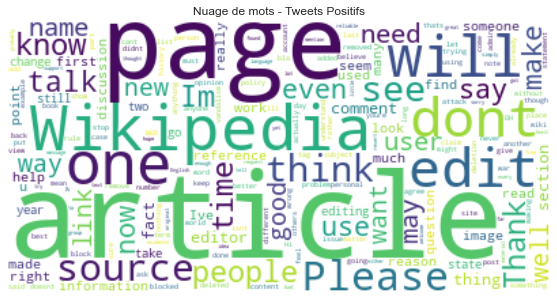

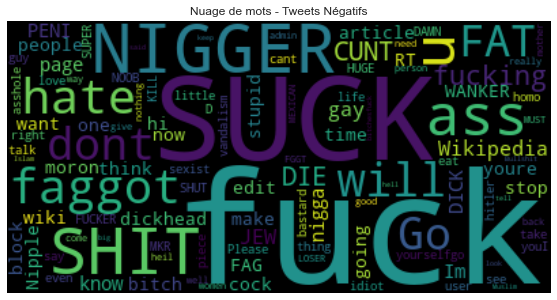

In [8]:
from wordcloud import WordCloud

# Joindre les tweets positifs et négatifs
text_pos = " ".join(df['tweet'][df['label'] == 0])
text_neg = " ".join(df['tweet'][df['label'] == 1])

# Générer les nuages de mots
train_cloud_pos = WordCloud(collocations=False, background_color='white').generate(text_pos)
train_cloud_neg = WordCloud(collocations=False, background_color='black').generate(text_neg)

# Afficher le nuage de mots positif
plt.figure(figsize=(10, 5))
plt.imshow(train_cloud_pos, interpolation='bilinear')
plt.axis('off')  # Ne pas afficher les axes
plt.title('Nuage de mots - Tweets Positifs')
plt.show()

# Afficher le nuage de mots négatif
plt.figure(figsize=(10, 5))
plt.imshow(train_cloud_neg, interpolation='bilinear')
plt.axis('off')  # Ne pas afficher les axes
plt.title('Nuage de mots - Tweets Négatifs')
plt.show()


In [9]:
# from transformers import BertTokenizer, BertModel
# import torch
# X = df['tweet'].to_list()
# y = df['label']
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained('bert-base-uncased')
#
# inputs = tokenizer(X, return_tensors='pt', padding=True, truncation=True, max_length=512)
# with torch.no_grad():
#     outputs = model(**inputs)
#
# # Prendre les embeddings des phrases (moyenne des embeddings des tokens)
# embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
# embeddings

In [28]:
df_positif = df[df['label'] == 0].head(15000)
df_negatif = df[df['label'] == 1].head(15000)

df_equilibre = pd.concat([df_positif, df_negatif], ignore_index=True)

In [55]:
df_equilibre[df_equilibre.index == 15140]["tweet"].tolist()[0]

'YOU FUCKING KIKE DONT EDIT THINGS YOU HAVE NO IDEA ABOUT GIVE CREDIT WHERE ITS DUE YOU FUCKING KIKE DONT EDIT THINGS YOU HAVE NO IDEA ABOUT GIVE CREDIT WHERE ITS DUE YOU FUCKING KIKE DONT EDIT THINGS YOU HAVE NO IDEA ABOUT GIVE CREDIT WHERE ITS DUE YOU FUCKING KIKE DONT EDIT THINGS YOU HAVE NO IDEA ABOUT GIVE CREDIT WHERE ITS DUE YOU FUCKING KIKE DONT EDIT THINGS YOU HAVE NO IDEA ABOUT GIVE CREDIT WHERE ITS DUE YOU FUCKING KIKE DONT EDIT THINGS YOU HAVE NO IDEA ABOUT GIVE CREDIT WHERE ITS DUE YOU FUCKING KIKE DONT EDIT THINGS YOU HAVE NO IDEA ABOUT GIVE CREDIT WHERE ITS DUE YOU FUCKING KIKE DONT EDIT THINGS YOU HAVE NO IDEA ABOUT GIVE CREDIT WHERE ITS DUE YOU FUCKING KIKE DONT EDIT THINGS YOU HAVE NO IDEA ABOUT GIVE CREDIT WHERE ITS DUE YOU FUCKING KIKE DONT EDIT THINGS YOU HAVE NO IDEA ABOUT GIVE CREDIT WHERE ITS DUE YOU FUCKING KIKE DONT EDIT THINGS YOU HAVE NO IDEA ABOUT GIVE CREDIT WHERE ITS DUE YOU FUCKING KIKE DONT EDIT THINGS YOU HAVE NO IDEA ABOUT GIVE CREDIT WHERE ITS DUE YOU

In [29]:
cv = CountVectorizer(max_features=2000)
x = cv.fit_transform(df_equilibre['tweet']).toarray()
y = df_equilibre['label']
x

array([[0, 0, 2, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [30]:
x.shape

(30000, 2000)

# Train & Test splitting the Data

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=1)

## Decision Tree, regression logistic, Random Forest

## Decision Tree

In [35]:
# Using Decision Tree

classifier_dt = DecisionTreeClassifier(criterion='entropy', random_state=0)

classifier_dt.fit(x_train, y_train)


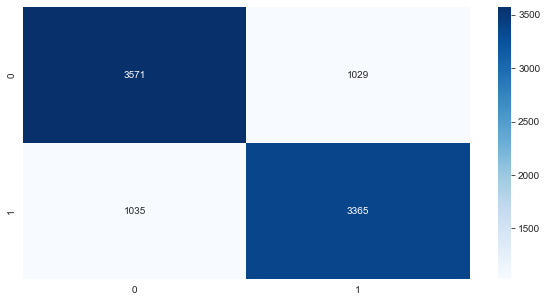

In [37]:
#matrice de confusion
result = classifier_dt.predict(x_test)
cm = confusion_matrix(y_test, result)
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()


## Logistic Regression

In [46]:
# Using Logistic Regression

classifier_lr = LogisticRegression(random_state=0)
classifier_lr.fit(x_train, y_train)


C:\Users\thoma\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
result = classifier_lr.predict(x_test)

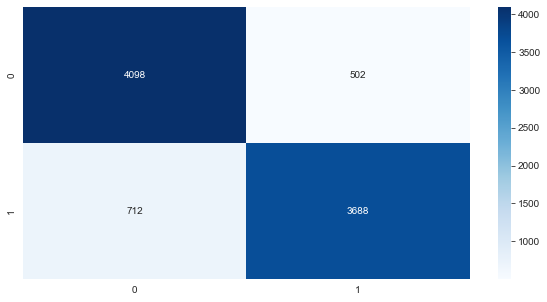

In [49]:
#matrice de confusion
cm = confusion_matrix(y_test, result)
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()


## Random Forest

In [43]:
# Using Random Forest

classifier_rf = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)

classifier_rf.fit(x_train, y_train)


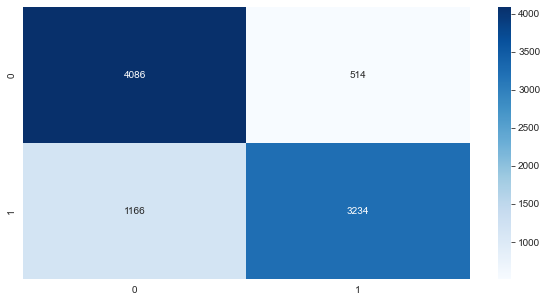

In [45]:
result = classifier_rf.predict(x_test)
#matrice de confusion
cm = confusion_matrix(y_test, result)
plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()


In [ ]:
y_pred_dt = classifier_dt.predict(x_test)
print('Decision Tree')
y_pred_lr = classifier_lr.predict(x_test)
print("Logistic Regression")
y_pred_rf = classifier_rf.predict(x_test)
print('Random Forest')

# Generating the Accuracy & F1 Score

In [ ]:
rf_score = accuracy_score(y_test, y_pred_rf)
lr_score = accuracy_score(y_test, y_pred_lr)
dt_score = accuracy_score(y_test, y_pred_dt)

print('--' * 20)
print('Random Forest Accuracy: ', str(rf_score))
print('F1 score: ', f1_score(y_test, y_pred_rf, labels=[1, 0]))
print('--' * 20)
print('')
print('--' * 20)
print('Logistic Regression Accuracy: ', str(lr_score))
print('F1 score: ', f1_score(y_test, y_pred_lr, labels=[1, 0]))
print('--' * 20)
print('')
print('--' * 20)
print('Decision Tree Accuracy: ', str(dt_score))
print('F1 score: ', f1_score(y_test, y_pred_dt, labels=[1, 0]))
print('--' * 20)
print('')

In [ ]:
test_custom = ["yo men you very big piece of shit, suck my dick big nerd", "i love you i'm your fan",
               "shut up niggers, your little bitch s"]
df_custom = pd.DataFrame(test_custom, columns=["tweet"])
df_custom

In [ ]:
# test_vectors = np.array([doc2vec_model.infer_vector(tweet.split()) for tweet in test_custom])
# test_vectors

In [ ]:
# y_test_transform = classifier_rf.predict(test_vectors)
# y_test_transform